In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%config InlineBackend.figure_format = 'retina'

# Preprocessing

In [2]:
data_path = 'Time_Series'
fnames = [fname for fname in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, fname))]
print(len(fnames), "files")

1146 files


In [3]:
def process_original(past_m0=0):
    data_full = []
    row = 44 - past_m0
    col = 7 + past_m0
    start_period = 1213 + past_m0
    for fname in fnames:
        data = pd.read_csv(os.path.join(data_path, fname), index_col=0)
        data = data.drop([' item'], axis=1)
        data.columns = ['qty', 'qty1', 'qty2', 'qty3']
        for i in range(past_m0):
            name = 'Last_M0' + str(i+1)
            data[name] = data['qty'].shift(i+1, axis=0)
        data['M0'] = data['qty']
        data['M1'] = data['qty'].shift(-1, axis=0)
        data['M2'] = data['qty'].shift(-2, axis=0)
        data['M3'] = data['qty'].shift(-3, axis=0)
        data = data.drop(['qty'], axis=1)
        data = data.dropna(how='any', axis=0)
        temp = np.zeros((row, col))  # this should be modified
        for i in range(start_period, 1257):
            try:
                temp[i-start_period] = data.loc[i].values
            except:
                continue
        data_full.append(temp)
    return data_full, ['original', past_m0]

def process_diagonal(past_m0=0):
    data_full = []
    if past_m0 <= 2:
        row = 42
    else:
        row = 42 - past_m0
    col = 10 + past_m0
    start_period = 1215 + past_m0
    for fname in fnames:
        data = pd.read_csv(os.path.join(data_path, fname), index_col=0)
        data = data.drop([' item'], axis=1)
        data.columns = ['qty', 'qty1', 'qty2', 'qty3']
        data['x1_for_m0'] = data['qty1']
        data['x2_for_m0'] = data['qty2'].shift(1, axis=0)
        data['x3_for_m0'] = data['qty3'].shift(2, axis=0)
        data['x1_for_m1'] = data['qty2']
        data['x2_for_m1'] = data['qty3'].shift(2, axis=0)
        data['x1_for_m2'] = data['qty3']
        for i in range(past_m0):
            name = 'Last_M0' + str(i+1)
            data[name] = data['qty'].shift(i+1, axis=0)
        data['M0'] = data['qty']
        data['M1'] = data['qty'].shift(-1, axis=0)
        data['M2'] = data['qty'].shift(-2, axis=0)
        data['M3'] = data['qty'].shift(-3, axis=0)
        data = data.drop(['qty', 'qty1', 'qty2', 'qty3'], axis=1)
        data = data.dropna(how='any', axis=0)

        temp = np.zeros((row, col))  # this should be modified
        for i in range(start_period, 1257):
            try:
                temp[i-start_period] = data.loc[i].values
            except:
                continue
        data_full.append(temp)
    return data_full, ['diagonal', past_m0]

In [4]:
def split(past_days, status, m):
    if status[0] == 'original':
        split_ind = 38 - status[1]
    if status[0] == 'diagonal':
        if status[1] <= 2:
            split_ind = 36
        else:
            split_ind = 36 - status[1]
    X_train, Y_train = [], []
    X_test, Y_test = [], []
    for ind in range(past_days, split_ind):
        for item_ind in range(len(fnames)):
            X_train.append(data_full[item_ind][ind - past_days: ind + 1][:, :-4])
            Y_train.append(data_full[item_ind][ind][-4:]) # change the number of y

    for ind in range(split_ind, split_ind + 6):
        for item_ind in range(len(fnames)):
            X_test.append(data_full[item_ind][ind - past_days: ind + 1][:, :-4])
            Y_test.append(data_full[item_ind][ind][-4:]) # change the number of y
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    if past_days == 0:
        X_train, Y_train, X_test, Y_test = \
        np.squeeze(X_train), np.squeeze(Y_train), np.squeeze(X_test), np.squeeze(Y_test) 
#     print("The shape of X_train:", X_train.shape)
#     print("The shape of Y_train:", Y_train.shape)
#     print("The shape of X_test:", X_test.shape)
#     print("The shape of Y_train:", Y_test.shape)
    # Only Predict M
    if m == 0:
        Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1)
        Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1)
    if m == 1:
        Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1)
        Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1)
    if m == 2:
        Y_train = Y_train[:, 2].reshape(Y_train.shape[0], 1)
        Y_test = Y_test[:, 2].reshape(Y_test.shape[0], 1)
    if m == 3:
        Y_train = Y_train[:, 3].reshape(Y_train.shape[0], 1)
        Y_test = Y_test[:, 3].reshape(Y_test.shape[0], 1)
    
    return X_train, Y_train, X_test, Y_test

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# gpu = tf.config.experimental.list_physical_devices('GPU')[0]
# tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
def build_rnn(verbose=1):
    epochs, batch_size = 20, 30
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
    np.random.seed(42)
    tf.random.set_seed(42)
    model = keras.models.Sequential()
#     model.add(keras.layers.GRU(60, return_sequences=True, input_shape=(n_timesteps, n_features)))
#     model.add(keras.layers.SimpleRNN(30))
    model.add(keras.layers.LSTM(75, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
    model.add(keras.layers.LSTM(30, return_sequences=True))
    model.add(keras.layers.LSTM(30))
    model.add(keras.layers.Dense(30, activation='relu'))
    model.add(keras.layers.Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    if verbose == 1:
        model.summary()
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, 
                        callbacks=[keras.callbacks.EarlyStopping(patience=10)],
                        validation_data=(X_test, Y_test))
    return model, history

In [7]:
def build_nn(verbose=1):
    epochs, batch_size = 20, 30
    np.random.seed(42)
    tf.random.set_seed(42)
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(80, activation='relu', input_dim=X_train.shape[1], kernel_initializer='normal'))
    model.add(keras.layers.Dense(40, kernel_initializer='normal'))
    model.add(keras.layers.Dense(40, kernel_initializer='normal'))
    model.add(keras.layers.Dense(40, kernel_initializer='normal'))
    model.add(keras.layers.Dense(20, kernel_initializer='normal'))
    model.add(keras.layers.Dense(Y_train.shape[1]))
    model.compile(loss='mse', optimizer='adam')
    if verbose == 1:
        model.summary()
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, 
                        callbacks=[keras.callbacks.EarlyStopping(patience=10)],
                        validation_data=(X_test, Y_test))
    return model, history

In [8]:
def my_acc(Y_pred_test, Y_test):
    acc = []
    for index, value in enumerate(Y_pred_test):
        if max(Y_test[index], Y_pred_test[index]) == 0:
            acc.append(np.nan)
            continue
        acc.append((min(Y_test[index], Y_pred_test[index])/max(Y_test[index], Y_pred_test[index]))[0])
    return np.nanmean(acc)

## MLP

Features from 0 to 30. Adding different period of past m0.

### Original

In [498]:
Past_M0 = []
MSE = []
ACC = []
for past_m0 in range(31):
    print("Preprocessing...PastM0 =", past_m0)
    data_full, status = process_original(past_m0)
#     data_full, status = process_diagonal(past_m0)
    X_train, Y_train, X_test, Y_test = split(0, status)
    print("Training...PastM0 =", past_m0)
    model, history = build_nn(verbose=0)
    mse_test = model.evaluate(X_test, Y_test)
    Y_pred_test = model.predict(X_test)
    acc = my_acc(Y_pred_test, Y_test)
    print('MSE:', mse_test, 'ACC:', acc)
    Past_M0.append(past_m0)
    MSE.append(mse_test)
    ACC.append(acc)

Preprocessing...PastM0 = 0
Training...PastM0 = 0
215/215 [==============================] - 0s 674us/step - loss: 0.0184
MSE: 0.01843119226396084 ACC: 0.710438728984101
Preprocessing...PastM0 = 1
Training...PastM0 = 1
215/215 [==============================] - 0s 697us/step - loss: 0.0182
MSE: 0.01815969869494438 ACC: 0.6933836725425907
Preprocessing...PastM0 = 2
Training...PastM0 = 2
215/215 [==============================] - 0s 661us/step - loss: 0.0174
MSE: 0.01744268275797367 ACC: 0.6946974047946305
Preprocessing...PastM0 = 3
Training...PastM0 = 3
215/215 [==============================] - 0s 663us/step - loss: 0.0178
MSE: 0.017814211547374725 ACC: 0.6912208126530818
Preprocessing...PastM0 = 4
Training...PastM0 = 4
215/215 [==============================] - 0s 659us/step - loss: 0.0177
MSE: 0.017716147005558014 ACC: 0.6854401664279155
Preprocessing...PastM0 = 5
Training...PastM0 = 5
215/215 [==============================] - 0s 643us/step - loss: 0.0172
MSE: 0.01719162054359913 ACC

In [507]:
mlp_original = pd.DataFrame({'Past M0': Past_M0,
                             'MSE': MSE,
                             'ACC': ACC})
mlp_original.to_csv('output/mlp_original.csv', index=False)

#### Predict M1

In [516]:
Past_M0 = []
MSE_1 = []
ACC_1 = []
for past_m0 in range(31):
    print("Preprocessing...PastM0 =", past_m0)
    data_full, status = process_original(past_m0)
#     data_full, status = process_diagonal(past_m0)
    X_train, Y_train, X_test, Y_test = split(0, status)
    print("Training...PastM0 =", past_m0)
    model, history = build_nn(verbose=0)
    mse_test = model.evaluate(X_test, Y_test)
    Y_pred_test = model.predict(X_test)
    acc = my_acc(Y_pred_test, Y_test)
    print('MSE:', mse_test, 'ACC:', acc)
    Past_M0.append(past_m0)
    MSE_1.append(mse_test)
    ACC_1.append(acc)

Preprocessing...PastM0 = 0
Training...PastM0 = 0
215/215 [==============================] - 0s 653us/step - loss: 0.0540
MSE: 0.05402820184826851 ACC: 0.5648874248092898
Preprocessing...PastM0 = 1
Training...PastM0 = 1
215/215 [==============================] - 0s 661us/step - loss: 0.0501
MSE: 0.05006590113043785 ACC: 0.5780307879029427
Preprocessing...PastM0 = 2
Training...PastM0 = 2
215/215 [==============================] - 0s 700us/step - loss: 0.0511
MSE: 0.051149144768714905 ACC: 0.5795607514419144
Preprocessing...PastM0 = 3
Training...PastM0 = 3
215/215 [==============================] - 0s 669us/step - loss: 0.0474
MSE: 0.04735465347766876 ACC: 0.5804740108624105
Preprocessing...PastM0 = 4
Training...PastM0 = 4
215/215 [==============================] - 0s 694us/step - loss: 0.0507
MSE: 0.05071078613400459 ACC: 0.5751915658627342
Preprocessing...PastM0 = 5
Training...PastM0 = 5
215/215 [==============================] - 0s 654us/step - loss: 0.0471
MSE: 0.04712693765759468 ACC

In [517]:
mlp_original_1 = pd.DataFrame({'Past M0': Past_M0,
                             'MSE': MSE_1,
                             'ACC': ACC_1})
mlp_original_1.to_csv('output/mlp_original_1.csv', index=False)

#### Precict M2

In [521]:
Past_M0 = []
MSE_2 = []
ACC_2 = []
for past_m0 in range(31):
    print("Preprocessing...PastM0 =", past_m0)
    data_full, status = process_original(past_m0)
#     data_full, status = process_diagonal(past_m0)
    X_train, Y_train, X_test, Y_test = split(0, status)
    print("Training...PastM0 =", past_m0)
    model, history = build_nn(verbose=0)
    mse_test = model.evaluate(X_test, Y_test)
    Y_pred_test = model.predict(X_test)
    acc = my_acc(Y_pred_test, Y_test)
    print('MSE:', mse_test, 'ACC:', acc)
    Past_M0.append(past_m0)
    MSE_2.append(mse_test)
    ACC_2.append(acc)

Preprocessing...PastM0 = 0
Training...PastM0 = 0
215/215 [==============================] - 0s 671us/step - loss: 0.0636
MSE: 0.06361240148544312 ACC: 0.5435478627855109
Preprocessing...PastM0 = 1
Training...PastM0 = 1
215/215 [==============================] - 0s 660us/step - loss: 0.0591
MSE: 0.059147100895643234 ACC: 0.5536637211485099
Preprocessing...PastM0 = 2
Training...PastM0 = 2
215/215 [==============================] - 0s 658us/step - loss: 0.0578
MSE: 0.05778547003865242 ACC: 0.5541081074328352
Preprocessing...PastM0 = 3
Training...PastM0 = 3
215/215 [==============================] - 0s 659us/step - loss: 0.0570
MSE: 0.05703865364193916 ACC: 0.5568206597056559
Preprocessing...PastM0 = 4
Training...PastM0 = 4
215/215 [==============================] - 0s 674us/step - loss: 0.0565
MSE: 0.056508149951696396 ACC: 0.585236839544384
Preprocessing...PastM0 = 5
Training...PastM0 = 5
215/215 [==============================] - 0s 697us/step - loss: 0.0582
MSE: 0.05818692594766617 ACC

In [522]:
mlp_original_2 = pd.DataFrame({'Past M0': Past_M0,
                             'MSE': MSE_2,
                             'ACC': ACC_2})
mlp_original_2.to_csv('output/mlp_original_2.csv', index=False)

#### Precict M3

In [525]:
Past_M0 = []
MSE_3 = []
ACC_3 = []
for past_m0 in range(31):
    print("Preprocessing...PastM0 =", past_m0)
    data_full, status = process_original(past_m0)
#     data_full, status = process_diagonal(past_m0)
    X_train, Y_train, X_test, Y_test = split(0, status)
    print("Training...PastM0 =", past_m0)
    model, history = build_nn(verbose=0)
    mse_test = model.evaluate(X_test, Y_test)
    Y_pred_test = model.predict(X_test)
    acc = my_acc(Y_pred_test, Y_test)
    print('MSE:', mse_test, 'ACC:', acc)
    Past_M0.append(past_m0)
    MSE_3.append(mse_test)
    ACC_3.append(acc)

Preprocessing...PastM0 = 0
Training...PastM0 = 0
215/215 [==============================] - 0s 735us/step - loss: 0.0676
MSE: 0.0676136165857315 ACC: 0.5283652603554184
Preprocessing...PastM0 = 1
Training...PastM0 = 1
215/215 [==============================] - 0s 657us/step - loss: 0.0658
MSE: 0.06582870334386826 ACC: 0.5322177300770625
Preprocessing...PastM0 = 2
Training...PastM0 = 2
215/215 [==============================] - 0s 671us/step - loss: 0.0624
MSE: 0.06243722885847092 ACC: 0.5359067607100124
Preprocessing...PastM0 = 3
Training...PastM0 = 3
215/215 [==============================] - 0s 692us/step - loss: 0.0606
MSE: 0.06061472371220589 ACC: 0.5427660904208312
Preprocessing...PastM0 = 4
Training...PastM0 = 4
215/215 [==============================] - 0s 649us/step - loss: 0.0621
MSE: 0.0621316134929657 ACC: 0.5621819292372868
Preprocessing...PastM0 = 5
Training...PastM0 = 5
215/215 [==============================] - 0s 649us/step - loss: 0.0582
MSE: 0.05819344148039818 ACC: 0

In [526]:
mlp_original_3 = pd.DataFrame({'Past M0': Past_M0,
                             'MSE': MSE_3,
                             'ACC': ACC_3})
mlp_original_3.to_csv('output/mlp_original_3.csv', index=False)

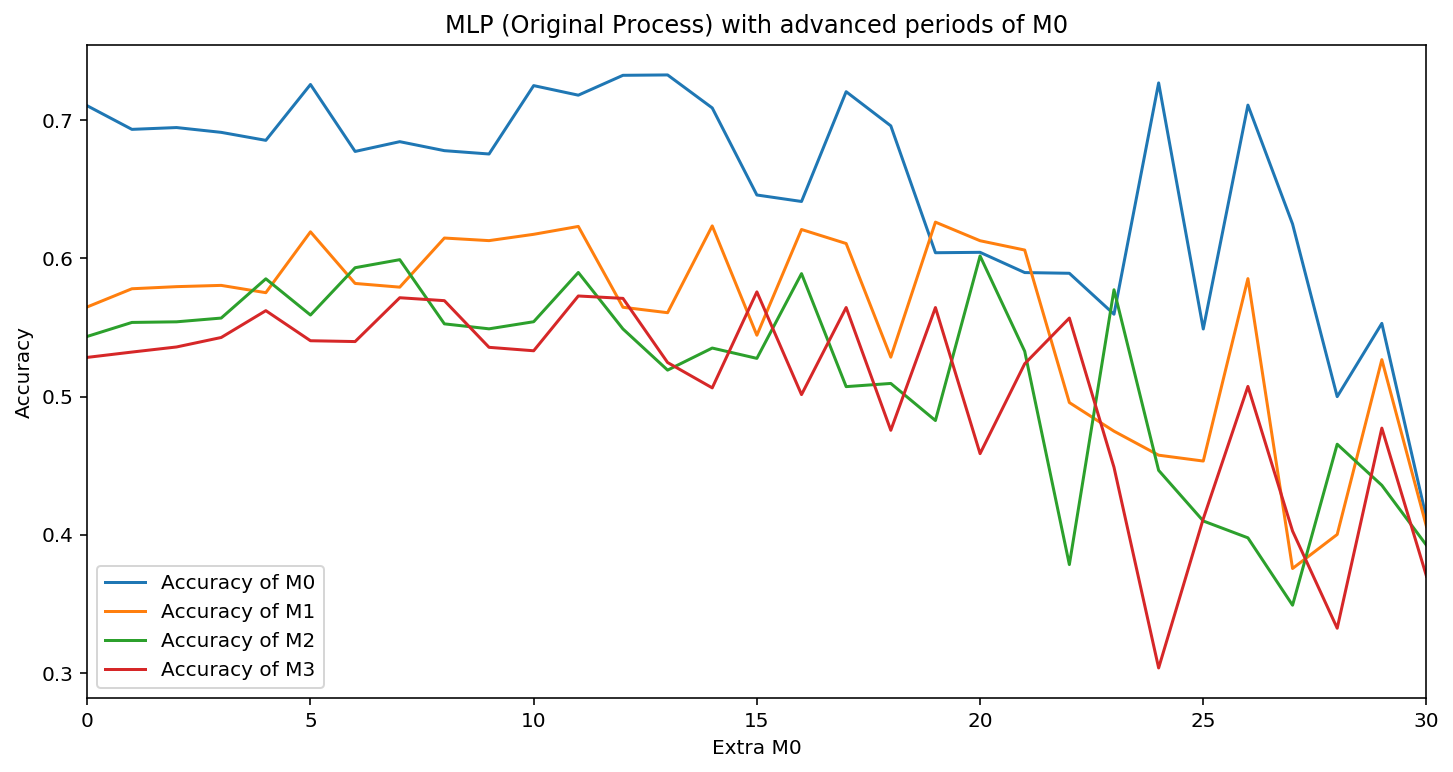

In [539]:
plt.figure(figsize=(12, 6))
# mlp_original['MSE'].plot()
mlp_original['ACC'].plot(label='Accuracy of M0')
mlp_original_1['ACC'].plot(label='Accuracy of M1')
mlp_original_2['ACC'].plot(label='Accuracy of M2')
mlp_original_3['ACC'].plot(label='Accuracy of M3')
plt.title('MLP (Original Process) with advanced periods of M0')
plt.xlabel('Extra M0')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('figures/mlp_original.png', dpi=300)
# plt.show()

### Diagonal

#### Predict M0

In [529]:
D_Past_M0 = []
D_MSE = []
D_ACC = []
for past_m0 in range(31):
    print("Preprocessing...PastM0 =", past_m0)
#     data_full, status = process_original(past_m0)
    data_full, status = process_diagonal(past_m0)
    X_train, Y_train, X_test, Y_test = split(0, status, 0)
    print("Training...PastM0 =", past_m0)
    model, history = build_nn(verbose=0)
    mse_test = model.evaluate(X_test, Y_test)
    Y_pred_test = model.predict(X_test)
    acc = my_acc(Y_pred_test, Y_test)
    print('MSE:', mse_test, 'ACC:', acc)
    D_Past_M0.append(past_m0)
    D_MSE.append(mse_test)
    D_ACC.append(acc)

Preprocessing...PastM0 = 0
Training...PastM0 = 0
215/215 [==============================] - 0s 649us/step - loss: 0.0185
MSE: 0.018480168655514717 ACC: 0.6865731940329662
Preprocessing...PastM0 = 1
Training...PastM0 = 1
215/215 [==============================] - 0s 666us/step - loss: 0.0152
MSE: 0.01522227842360735 ACC: 0.5771575758124818
Preprocessing...PastM0 = 2
Training...PastM0 = 2
215/215 [==============================] - 0s 650us/step - loss: 0.0127
MSE: 0.012735631316900253 ACC: 0.4541654675287844
Preprocessing...PastM0 = 3
Training...PastM0 = 3
215/215 [==============================] - 0s 665us/step - loss: 0.0169
MSE: 0.016931625083088875 ACC: 0.7227893011669295
Preprocessing...PastM0 = 4
Training...PastM0 = 4
215/215 [==============================] - 0s 680us/step - loss: 0.0169
MSE: 0.016938112676143646 ACC: 0.6831407162829503
Preprocessing...PastM0 = 5
Training...PastM0 = 5
215/215 [==============================] - 0s 696us/step - loss: 0.0171
MSE: 0.01711459457874298 

In [530]:
mlp_diagonal = pd.DataFrame({'Past M0': D_Past_M0,
                             'MSE': D_MSE,
                             'ACC': D_ACC})#### Predict M3
mlp_diagonal.to_csv('output/mlp_diagonal.csv', index=False)

#### Predict M1

In [531]:
D_Past_M0 = []
D_MSE_1 = []
D_ACC_1 = []
for past_m0 in range(31):
    print("Preprocessing...PastM0 =", past_m0)
#     data_full, status = process_original(past_m0)
    data_full, status = process_diagonal(past_m0)
    X_train, Y_train, X_test, Y_test = split(0, status, 1)
    print("Training...PastM0 =", past_m0)
    model, history = build_nn(verbose=0)
    mse_test = model.evaluate(X_test, Y_test)
    Y_pred_test = model.predict(X_test)
    acc = my_acc(Y_pred_test, Y_test)
    print('MSE:', mse_test, 'ACC:', acc)
    D_Past_M0.append(past_m0)
    D_MSE_1.append(mse_test)
    D_ACC_1.append(acc)

Preprocessing...PastM0 = 0
Training...PastM0 = 0
215/215 [==============================] - 0s 641us/step - loss: 0.0557
MSE: 0.055731456726789474 ACC: 0.5629531941735287
Preprocessing...PastM0 = 1
Training...PastM0 = 1
215/215 [==============================] - 0s 649us/step - loss: 0.0430
MSE: 0.04302370175719261 ACC: 0.4785342927157283
Preprocessing...PastM0 = 2
Training...PastM0 = 2
215/215 [==============================] - 0s 647us/step - loss: 0.0349
MSE: 0.03494742885231972 ACC: 0.5951919882444134
Preprocessing...PastM0 = 3
Training...PastM0 = 3
215/215 [==============================] - 0s 646us/step - loss: 0.0486
MSE: 0.04857289046049118 ACC: 0.6097288552171747
Preprocessing...PastM0 = 4
Training...PastM0 = 4
215/215 [==============================] - 0s 654us/step - loss: 0.0492
MSE: 0.049206096678972244 ACC: 0.5803462491375961
Preprocessing...PastM0 = 5
Training...PastM0 = 5
215/215 [==============================] - 0s 652us/step - loss: 0.0459
MSE: 0.04587160795927048 AC

In [532]:
mlp_diagonal_1 = pd.DataFrame({'Past M0': D_Past_M0,
                             'MSE': D_MSE_1,
                             'ACC': D_ACC_1})
mlp_diagonal_1.to_csv('output/mlp_diagonal_1.csv', index=False)

#### Predict M2

In [533]:
D_Past_M0 = []
D_MSE_2 = []
D_ACC_2 = []
for past_m0 in range(31):
    print("Preprocessing...PastM0 =", past_m0)
#     data_full, status = process_original(past_m0)
    data_full, status = process_diagonal(past_m0)
    X_train, Y_train, X_test, Y_test = split(0, status, 2)
    print("Training...PastM0 =", past_m0)
    model, history = build_nn(verbose=0)
    mse_test = model.evaluate(X_test, Y_test)
    Y_pred_test = model.predict(X_test)
    acc = my_acc(Y_pred_test, Y_test)
    print('MSE:', mse_test, 'ACC:', acc)
    D_Past_M0.append(past_m0)
    D_MSE_2.append(mse_test)
    D_ACC_2.append(acc)

Preprocessing...PastM0 = 0
Training...PastM0 = 0
215/215 [==============================] - 0s 622us/step - loss: 0.0625
MSE: 0.0624755397439003 ACC: 0.543773409512735
Preprocessing...PastM0 = 1
Training...PastM0 = 1
215/215 [==============================] - 0s 604us/step - loss: 0.0511
MSE: 0.051133036613464355 ACC: 0.4549038950178037
Preprocessing...PastM0 = 2
Training...PastM0 = 2
215/215 [==============================] - 0s 604us/step - loss: 0.0321
MSE: 0.0320545956492424 ACC: 0.371810217588091
Preprocessing...PastM0 = 3
Training...PastM0 = 3
215/215 [==============================] - 0s 616us/step - loss: 0.0583
MSE: 0.0582854226231575 ACC: 0.5547872936754779
Preprocessing...PastM0 = 4
Training...PastM0 = 4
215/215 [==============================] - 0s 600us/step - loss: 0.0530
MSE: 0.05296289548277855 ACC: 0.5895602585697973
Preprocessing...PastM0 = 5
Training...PastM0 = 5
215/215 [==============================] - 0s 605us/step - loss: 0.0536
MSE: 0.05357174947857857 ACC: 0.5

In [534]:
mlp_diagonal_2 = pd.DataFrame({'Past M0': D_Past_M0,
                             'MSE': D_MSE_2,
                             'ACC': D_ACC_2})
mlp_diagonal_2.to_csv('output/mlp_diagonal_2.csv', index=False)

#### Predict M3

In [535]:
D_Past_M0 = []
D_MSE_3 = []
D_ACC_3 = []
for past_m0 in range(31):
    print("Preprocessing...PastM0 =", past_m0)
#     data_full, status = process_original(past_m0)
    data_full, status = process_diagonal(past_m0)
    X_train, Y_train, X_test, Y_test = split(0, status, 3)
    print("Training...PastM0 =", past_m0)
    model, history = build_nn(verbose=0)
    mse_test = model.evaluate(X_test, Y_test)
    Y_pred_test = model.predict(X_test)
    acc = my_acc(Y_pred_test, Y_test)
    print('MSE:', mse_test, 'ACC:', acc)
    D_Past_M0.append(past_m0)
    D_MSE_3.append(mse_test)
    D_ACC_3.append(acc)

Preprocessing...PastM0 = 0
Training...PastM0 = 0
215/215 [==============================] - 0s 605us/step - loss: 0.0661
MSE: 0.0660940557718277 ACC: 0.5252983162810405
Preprocessing...PastM0 = 1
Training...PastM0 = 1
215/215 [==============================] - 0s 602us/step - loss: 0.0442
MSE: 0.044231537729501724 ACC: 0.45092961734310005
Preprocessing...PastM0 = 2
Training...PastM0 = 2
215/215 [==============================] - 0s 607us/step - loss: 0.0355
MSE: 0.035470716655254364 ACC: 0.35969438316493835
Preprocessing...PastM0 = 3
Training...PastM0 = 3
215/215 [==============================] - 0s 605us/step - loss: 0.0634
MSE: 0.06335055828094482 ACC: 0.5629887470972562
Preprocessing...PastM0 = 4
Training...PastM0 = 4
215/215 [==============================] - 0s 609us/step - loss: 0.0599
MSE: 0.059888213872909546 ACC: 0.5400701510299616
Preprocessing...PastM0 = 5
Training...PastM0 = 5
215/215 [==============================] - 0s 606us/step - loss: 0.0583
MSE: 0.05831130966544151 

In [536]:
mlp_diagonal_3 = pd.DataFrame({'Past M0': D_Past_M0,
                             'MSE': D_MSE_3,
                             'ACC': D_ACC_3})
mlp_diagonal_3.to_csv('output/mlp_diagonal_3.csv', index=False)

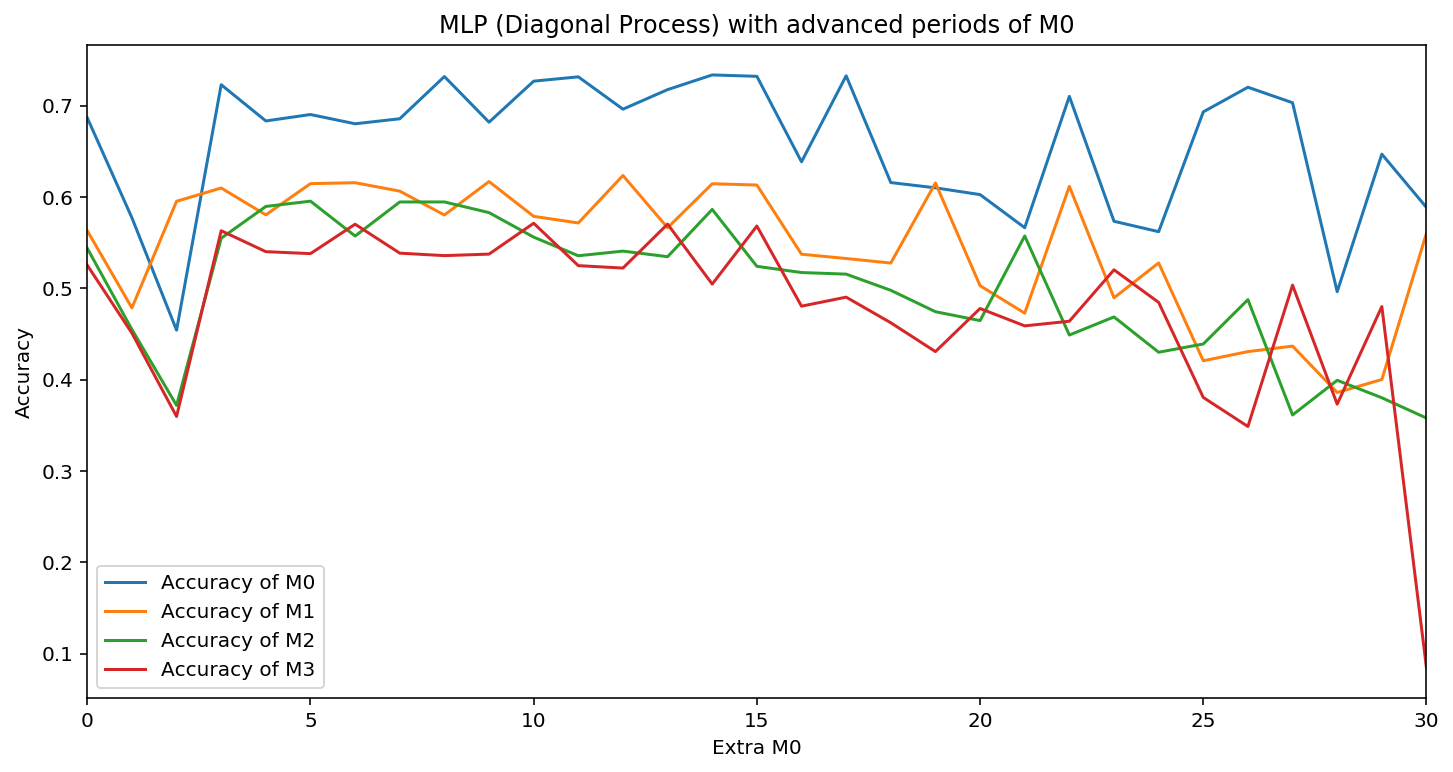

In [538]:
plt.figure(figsize=(12, 6))
# mlp_original['MSE'].plot()
mlp_diagonal['ACC'].plot(label='Accuracy of M0')
mlp_diagonal_1['ACC'].plot(label='Accuracy of M1')
mlp_diagonal_2['ACC'].plot(label='Accuracy of M2')
mlp_diagonal_3['ACC'].plot(label='Accuracy of M3')
plt.title('MLP (Diagonal Process) with advanced periods of M0')
plt.xlabel('Extra M0')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('figures/mlp_diagonal.png', dpi=300)
# plt.show()

## RNN

### Original

#### Predict M0

In [547]:
Past_M0 = []
rnn_MSE = []
rnn_ACC = []
for past_m0 in range(31):
    print("Preprocessing...Past_M0:", past_m0)
    data_full, status = process_original(past_m0)
#     data_full, status = process_diagonal(past_m0)
    X_train, Y_train, X_test, Y_test = split(1, status, 0)
    print("Training...Past_M0:", past_m0)
    model, history = build_rnn(verbose=0)
    mse_test = model.evaluate(X_test, Y_test)
    Y_pred_test = model.predict(X_test)
    acc = my_acc(Y_pred_test, Y_test)
    print('MSE:', mse_test, 'ACC:', acc)
    Past_M0.append(past_m0)
    rnn_MSE.append(mse_test)
    rnn_ACC.append(acc)

Preprocessing...Past_M0: 0
Training...Past_M0: 0
215/215 [==============================] - 0s 1ms/step - loss: 0.0185
MSE: 0.01851416938006878 ACC: 0.6908261723555262
Preprocessing...Past_M0: 1
Training...Past_M0: 1
215/215 [==============================] - 0s 2ms/step - loss: 0.0167
MSE: 0.01670866832137108 ACC: 0.6990205283984265
Preprocessing...Past_M0: 2
Training...Past_M0: 2
215/215 [==============================] - 0s 2ms/step - loss: 0.0172
MSE: 0.01723969727754593 ACC: 0.6984299662204337
Preprocessing...Past_M0: 3
Training...Past_M0: 3
215/215 [==============================] - 0s 2ms/step - loss: 0.0173
MSE: 0.017301183193922043 ACC: 0.7007742311933481
Preprocessing...Past_M0: 4
Training...Past_M0: 4
215/215 [==============================] - 0s 2ms/step - loss: 0.0166
MSE: 0.016557330265641212 ACC: 0.6934759769398223
Preprocessing...Past_M0: 5
Training...Past_M0: 5
215/215 [==============================] - 0s 2ms/step - loss: 0.0161
MSE: 0.016063757240772247 ACC: 0.690397

In [548]:
rnn_original = pd.DataFrame({'Past M0': Past_M0,
                             'MSE': rnn_MSE,
                             'ACC': rnn_ACC})
rnn_original.to_csv('output/rnn_original.csv', index=False)

#### Predict M1

In [549]:
Past_M0 = []
rnn_MSE_1 = []
rnn_ACC_1 = []
for past_m0 in range(31):
    print("Preprocessing...Past_M0:", past_m0)
    data_full, status = process_original(past_m0)
#     data_full, status = process_diagonal(past_m0)
    X_train, Y_train, X_test, Y_test = split(1, status, 1)
    print("Training...Past_M0:", past_m0)
    model, history = build_rnn(verbose=0)
    mse_test = model.evaluate(X_test, Y_test)
    Y_pred_test = model.predict(X_test)
    acc = my_acc(Y_pred_test, Y_test)
    print('MSE:', mse_test, 'ACC:', acc)
    Past_M0.append(past_m0)
    rnn_MSE_1.append(mse_test)
    rnn_ACC_1.append(acc)

Preprocessing...Past_M0: 0
Training...Past_M0: 0
215/215 [==============================] - 0s 2ms/step - loss: 0.0515
MSE: 0.051475126296281815 ACC: 0.5763577736757496
Preprocessing...Past_M0: 1
Training...Past_M0: 1
215/215 [==============================] - 0s 2ms/step - loss: 0.0496
MSE: 0.04959583654999733 ACC: 0.5845572867850982
Preprocessing...Past_M0: 2
Training...Past_M0: 2
215/215 [==============================] - 0s 2ms/step - loss: 0.0470
MSE: 0.046983323991298676 ACC: 0.583445168849307
Preprocessing...Past_M0: 3
Training...Past_M0: 3
215/215 [==============================] - 0s 2ms/step - loss: 0.0469
MSE: 0.04685397446155548 ACC: 0.5843575645023044
Preprocessing...Past_M0: 4
Training...Past_M0: 4
215/215 [==============================] - 0s 1ms/step - loss: 0.0438
MSE: 0.043758146464824677 ACC: 0.5874236719589859
Preprocessing...Past_M0: 5
Training...Past_M0: 5
215/215 [==============================] - 0s 2ms/step - loss: 0.0441
MSE: 0.04406362771987915 ACC: 0.5906941

In [550]:
rnn_original_1 = pd.DataFrame({'Past M0': Past_M0,
                             'MSE': rnn_MSE_1,
                             'ACC': rnn_ACC_1})
rnn_original_1.to_csv('output/rnn_original_1.csv', index=False)

#### Predict M2

In [551]:
Past_M0 = []
rnn_MSE_2 = []
rnn_ACC_2 = []
for past_m0 in range(31):
    print("Preprocessing...Past_M0:", past_m0)
    data_full, status = process_original(past_m0)
#     data_full, status = process_diagonal(past_m0)
    X_train, Y_train, X_test, Y_test = split(1, status, 2)
    print("Training...Past_M0:", past_m0)
    model, history = build_rnn(verbose=0)
    mse_test = model.evaluate(X_test, Y_test)
    Y_pred_test = model.predict(X_test)
    acc = my_acc(Y_pred_test, Y_test)
    print('MSE:', mse_test, 'ACC:', acc)
    Past_M0.append(past_m0)
    rnn_MSE_2.append(mse_test)
    rnn_ACC_2.append(acc)

Preprocessing...Past_M0: 0
Training...Past_M0: 0
215/215 [==============================] - 0s 2ms/step - loss: 0.0611
MSE: 0.06107456237077713 ACC: 0.5523951801521995
Preprocessing...Past_M0: 1
Training...Past_M0: 1
215/215 [==============================] - 0s 2ms/step - loss: 0.0581
MSE: 0.05806290730834007 ACC: 0.5580180176596368
Preprocessing...Past_M0: 2
Training...Past_M0: 2
215/215 [==============================] - 0s 1ms/step - loss: 0.0557
MSE: 0.055731553584337234 ACC: 0.5585757944254791
Preprocessing...Past_M0: 3
Training...Past_M0: 3
215/215 [==============================] - 0s 2ms/step - loss: 0.0557
MSE: 0.05566420406103134 ACC: 0.5830960031164829
Preprocessing...Past_M0: 4
Training...Past_M0: 4
215/215 [==============================] - 0s 2ms/step - loss: 0.0559
MSE: 0.05588638782501221 ACC: 0.5854539755077518
Preprocessing...Past_M0: 5
Training...Past_M0: 5
215/215 [==============================] - 0s 1ms/step - loss: 0.0525
MSE: 0.052497733384370804 ACC: 0.5888544

In [552]:
rnn_original_2 = pd.DataFrame({'Past M0': Past_M0,
                             'MSE': rnn_MSE_2,
                             'ACC': rnn_ACC_2})
rnn_original_2.to_csv('output/rnn_original_2.csv', index=False)

#### Predict M3

In [553]:
Past_M0 = []
rnn_MSE_3 = []
rnn_ACC_3 = []
for past_m0 in range(31):
    print("Preprocessing...Past_M0:", past_m0)
    data_full, status = process_original(past_m0)
#     data_full, status = process_diagonal(past_m0)
    X_train, Y_train, X_test, Y_test = split(1, status, 3)
    print("Training...Past_M0:", past_m0)
    model, history = build_rnn(verbose=0)
    mse_test = model.evaluate(X_test, Y_test)
    Y_pred_test = model.predict(X_test)
    acc = my_acc(Y_pred_test, Y_test)
    print('MSE:', mse_test, 'ACC:', acc)
    Past_M0.append(past_m0)
    rnn_MSE_3.append(mse_test)
    rnn_ACC_3.append(acc)

Preprocessing...Past_M0: 0
Training...Past_M0: 0
215/215 [==============================] - 0s 2ms/step - loss: 0.0669
MSE: 0.06688640266656876 ACC: 0.5343217996150084
Preprocessing...Past_M0: 1
Training...Past_M0: 1
215/215 [==============================] - 0s 2ms/step - loss: 0.0626
MSE: 0.06260165572166443 ACC: 0.5565371478491923
Preprocessing...Past_M0: 2
Training...Past_M0: 2
215/215 [==============================] - 0s 2ms/step - loss: 0.0607
MSE: 0.06073125824332237 ACC: 0.545384273924259
Preprocessing...Past_M0: 3
Training...Past_M0: 3
215/215 [==============================] - 0s 2ms/step - loss: 0.0624
MSE: 0.062379177659749985 ACC: 0.5408097692146231
Preprocessing...Past_M0: 4
Training...Past_M0: 4
215/215 [==============================] - 0s 2ms/step - loss: 0.0582
MSE: 0.058240748941898346 ACC: 0.5490247842808222
Preprocessing...Past_M0: 5
Training...Past_M0: 5
215/215 [==============================] - 0s 2ms/step - loss: 0.0597
MSE: 0.0596700981259346 ACC: 0.563872759

In [554]:
rnn_original_3 = pd.DataFrame({'Past M0': Past_M0,
                             'MSE': rnn_MSE_3,
                             'ACC': rnn_ACC_3})
rnn_original_3.to_csv('output/rnn_original_3.csv', index=False)

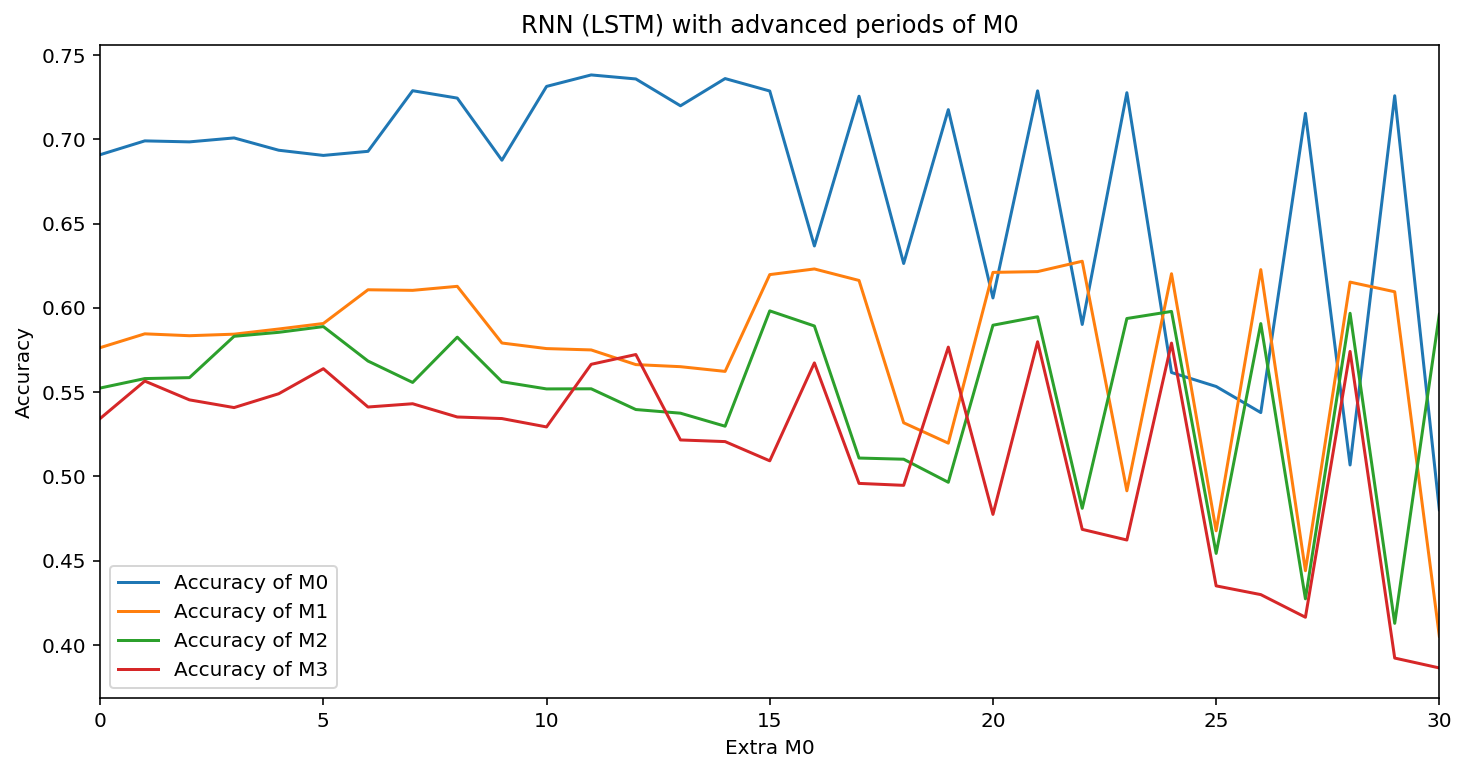

In [556]:
plt.figure(figsize=(12, 6))
# mlp_original['MSE'].plot()
rnn_original['ACC'].plot(label='Accuracy of M0')
rnn_original_1['ACC'].plot(label='Accuracy of M1')
rnn_original_2['ACC'].plot(label='Accuracy of M2')
rnn_original_3['ACC'].plot(label='Accuracy of M3')
plt.title('RNN (LSTM) with advanced periods of M0')
plt.xlabel('Extra M0')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('figures/rnn_original.png', dpi=300)

# 给睿豪的

## M0

In [17]:
data_full, status = process_original(11)
X_train, Y_train, X_test, Y_test = split(1, status, 0)
model, history = build_rnn(verbose=1)
mse_test = model.evaluate(X_test, Y_test)
Y_pred_test = model.predict(X_test)  # 这个就是预测出来的东西
acc = my_acc(Y_pred_test, Y_test)
print('MSE:', mse_test, 'ACC:', acc)
np.savetxt('output/rnn_y_pred_test_m0.csv', Y_pred_test, delimiter=',')

mse_train = model.evaluate(X_train, Y_train)
Y_pred_train = model.predict(X_train)  # 这个就是预测出来的东西
acc = my_acc(Y_pred_train, Y_train)
print('MSE:', mse_train, 'ACC:', acc)
np.savetxt('output/rnn_y_pred_train_m0.csv', Y_pred_train, delimiter=',')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 2, 75)             27000     
_________________________________________________________________
lstm_16 (LSTM)               (None, 2, 30)             12720     
_________________________________________________________________
lstm_17 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_10 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 31        
Total params: 48,001
Trainable params: 48,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
994/994 [==============================] - 6s 6ms/step - loss: 0.0163 - val_loss: 0.0166
Epoch 2/20
994/9

## M1

In [18]:
data_full, status = process_original(22)
X_train, Y_train, X_test, Y_test = split(1, status, 1)
model, history = build_rnn(verbose=1)
mse_test = model.evaluate(X_test, Y_test)
Y_pred_test = model.predict(X_test)  # 这个就是预测出来的东西
acc = my_acc(Y_pred_test, Y_test)
print('MSE:', mse_test, 'ACC:', acc)
np.savetxt('output/rnn_y_pred_test_m1.csv', Y_pred_test, delimiter=',')

mse_train = model.evaluate(X_train, Y_train)
Y_pred_train = model.predict(X_train)  # 这个就是预测出来的东西
acc = my_acc(Y_pred_train, Y_train)
print('MSE:', mse_train, 'ACC:', acc)
np.savetxt('output/rnn_y_pred_train_m1.csv', Y_pred_train, delimiter=',')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 2, 75)             30300     
_________________________________________________________________
lstm_19 (LSTM)               (None, 2, 30)             12720     
_________________________________________________________________
lstm_20 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_12 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 31        
Total params: 51,301
Trainable params: 51,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
573/573 [==============================] - 4s 6ms/step - loss: 0.0315 - val_loss: 0.0375
Epoch 2/20
573/5

## M2

In [19]:
data_full, status = process_original(15)
X_train, Y_train, X_test, Y_test = split(1, status, 2)
model, history = build_rnn(verbose=1)
mse_test = model.evaluate(X_test, Y_test)
Y_pred_test = model.predict(X_test)  # 这个就是预测出来的东西
acc = my_acc(Y_pred_test, Y_test)
print('MSE:', mse_test, 'ACC:', acc)
np.savetxt('output/rnn_y_pred_test_m2.csv', Y_pred_test, delimiter=',')

mse_train = model.evaluate(X_train, Y_train)
Y_pred_train = model.predict(X_train)  # 这个就是预测出来的东西
acc = my_acc(Y_pred_train, Y_train)
print('MSE:', mse_train, 'ACC:', acc)
np.savetxt('output/rnn_y_pred_train_m2.csv', Y_pred_train, delimiter=',')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 2, 75)             28200     
_________________________________________________________________
lstm_22 (LSTM)               (None, 2, 30)             12720     
_________________________________________________________________
lstm_23 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_14 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 31        
Total params: 49,201
Trainable params: 49,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
841/841 [==============================] - 6s 7ms/step - loss: 0.0366 - val_loss: 0.0446
Epoch 2/20
841/8

## M3

In [20]:
data_full, status = process_original(21)
X_train, Y_train, X_test, Y_test = split(1, status, 3)
model, history = build_rnn(verbose=1)
mse_test = model.evaluate(X_test, Y_test)
Y_pred_test = model.predict(X_test)  # 这个就是预测出来的东西
acc = my_acc(Y_pred_test, Y_test)
print('MSE:', mse_test, 'ACC:', acc)
np.savetxt('output/rnn_y_pred_test_m3.csv', Y_pred_test, delimiter=',')

mse_train = model.evaluate(X_train, Y_train)
Y_pred_train = model.predict(X_train)  # 这个就是预测出来的东西
acc = my_acc(Y_pred_train, Y_train)
print('MSE:', mse_train, 'ACC:', acc)
np.savetxt('output/rnn_y_pred_train_m3.csv', Y_pred_train, delimiter=',')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 2, 75)             30000     
_________________________________________________________________
lstm_25 (LSTM)               (None, 2, 30)             12720     
_________________________________________________________________
lstm_26 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_16 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 31        
Total params: 51,001
Trainable params: 51,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
612/612 [==============================] - 5s 9ms/step - loss: 0.0338 - val_loss: 0.0438
Epoch 2/20
612/6

# 旧的东西

In [227]:
def acc_out(item_index, Y_test, Y_pred_test):
    item_ytest = []
    item_ypred = []
    count = 0
    for i in range(6):
        item_ytest.append(Y_test[item_index+count*1146])
        item_ypred.append(Y_pred_test[item_index+count*1146])
        count += 1
    acc = []
    for i in range(6):
        for index, value in enumerate(item_ypred[i]): 
            if  max(item_ytest[i][index], item_ypred[i][index]) == 0:
                acc.append(np.nan)
                continue
            acc.append(np.divide(min(item_ytest[i][index], item_ypred[i][index]),
                                 max(item_ytest[i][index], item_ypred[i][index])))
    acc = np.array(acc)
    acc = acc.reshape(6, 4)
    return acc

In [228]:
acc_list = []
for i in range(1146):
    acc_list.append(acc_out(i, Y_test, Y_pred_test))
acc_list = np.array(acc_list)

In [229]:
np.nanmean(acc_list, axis=0)

array([[0.72299333, 0.60833871, 0.58599514, 0.51206537],
       [0.72875323, 0.61218095, 0.51665058, 0.55755802],
       [0.72661241, 0.53988115, 0.56360106, 0.54952484],
       [0.71532251, 0.58289691, 0.55298451, 0.5532315 ],
       [0.73198945, 0.57444359, 0.56741276, 0.5566441 ],
       [0.72708826, 0.58047689, 0.55469504, 0.4949951 ]])

In [230]:
result = pd.DataFrame(np.nanmean(acc_list, axis=0))
result.columns = ['Accuracy of M0', 'Accuracy of M1', 
                  'Accuracy of M2', 'Accuracy of M3']
result['Accuracy of M012'] = (result.iloc[:, 0] + result.iloc[:, 1] + result.iloc[:, 2])/3
result['Accuracy of M123'] = (result.iloc[:, 1] + result.iloc[:, 2] + result.iloc[:, 3])/3
result

,Accuracy of M0,Accuracy of M1,Accuracy of M2,Accuracy of M3,Accuracy of M012,Accuracy of M123
0,0.722993,0.608339,0.585995,0.512065,0.639109,0.568800
1,0.728753,0.612181,0.516651,0.557558,0.619195,0.562130
2,0.726612,0.539881,0.563601,0.549525,0.610032,0.551002
3,0.715323,0.582897,0.552985,0.553232,0.617068,0.563038
4,0.731989,0.574444,0.567413,0.556644,0.624615,0.566167
5,0.727088,0.580477,0.554695,0.494995,0.620753,0.543389
